# K-Prototype for Item 

In [81]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.feature_extraction import FeatureHasher
from kmodes.kprototypes import KPrototypes
import plotly.express as px


In [82]:
# 1) Caricamento e pulizia
item = pd.read_csv(
    '../../datasets/ml-100k/u.item',
    sep='|',
    encoding='latin-1', 
    names=[
        'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_url',
        'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
    ]
)
item = item.drop(columns=['IMDb_url','video_release_date'])


In [ ]:
# 2) Gestione dei NaN sulla data

item['release_date'] = pd.to_datetime(item['release_date'], errors='coerce')
# Imputiamo i NaN con data fittizia basata sulla mediana
mediana_anno = item['release_date'].dt.year.median()
item['release_date'] = item['release_date'].fillna(pd.to_datetime(f'{int(mediana_anno)}-01-01'))


In [ ]:
# 3) Estrai anno come numerico

item['release_year'] = item['release_date'].dt.year.astype(int)


In [ ]:
# 4) Prepara le feature

generi = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# Matrice binaria dei generi
X_bin = item[generi].astype(int).values

# Normalizza l'anno in [0,1]
years = item[['release_year']].values.astype(float)
years_norm = MinMaxScaler().fit_transform(years)

# Combina in un unico array continuo per la silhouette euclidea
X_mix = np.hstack([X_bin, years_norm])


In [ ]:
costs      = []
sil_scores = []
K_range    = range(2, 11)
cat_idx    = list(range(len(generi)))  

for k in K_range:
    # Fit K-Prototypes
    kprot = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    labels = kprot.fit_predict(item[generi + ['release_year']], categorical=cat_idx)
    
    # Salva costo e silhouette
    costs.append(kprot.cost_)
    sil = silhouette_score(X_mix, labels, metric='euclidean')
    sil_scores.append(sil)

    print(f'k={k} → cost={kprot.cost_:.0f}, silhouette={sil:.4f}')

# Salva il k con la silhouette più alta
best_k = K_range[sil_scores.index(max(sil_scores))]
print(f'\n best_k = {best_k} (massima silhouette = {max(sil_scores):.4f})')


k=2 → cost=74532, silhouette=0.1110
k=3 → cost=45301, silhouette=0.0796
k=4 → cost=34554, silhouette=0.0670
k=5 → cost=30198, silhouette=0.1809
k=6 → cost=27725, silhouette=0.2323
k=7 → cost=24140, silhouette=0.1289
k=8 → cost=22349, silhouette=0.1035
k=9 → cost=20821, silhouette=0.0907
k=10 → cost=19398, silhouette=0.1929

 best_k = 6 (massima silhouette = 0.2323)


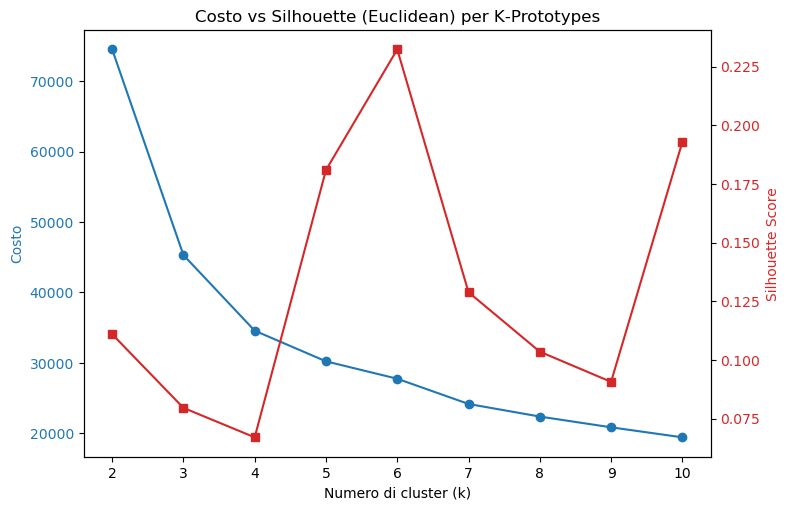

In [ ]:
# 6) Grafico Costo vs Silhouette

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(K_range, costs, '-o', color='tab:blue', label='Costo')
ax1.set_xlabel('Numero di cluster (k)')
ax1.set_ylabel('Costo', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(K_range, sil_scores, '-s', color='tab:red', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Costo vs Silhouette (Euclidean) per K‑Prototypes')
plt.show()

In [ ]:
# 1.1: Salva i label dell'ULTIMO modello

item['cluster_kproto'] = kprot.labels_  # usa direttamente i label finali

# 1.2: Dimensione di ogni cluster

cluster_sizes = item['cluster_kproto'].value_counts().sort_index()
print("Dimensione dei cluster:")
print(cluster_sizes)


Dimensione dei cluster:
cluster_kproto
0    546
1    112
2     34
3     58
4     45
5     62
6    367
7     46
8     34
9    378
Name: count, dtype: int64


In [89]:
import numpy as np
import umap
import plotly.graph_objects as go
from kmodes.kprototypes import KPrototypes

# 1. Prepara i dati
X_bin = item[generi].astype(int).values
X_num = item[['release_year']].values
X_mix = np.hstack([X_bin, X_num])

# 2. Clustering con K-Prototypes
kproto = KPrototypes(n_clusters=best_k, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(X_mix, categorical=list(range(X_bin.shape[1])))
item['cluster_kproto'] = clusters

# 3. UMAP per riduzione a 3D
reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(X_mix)

# 4. Plot interattivo 3D con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=embedding_3d[:, 0],
    y=embedding_3d[:, 1],
    z=embedding_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=item['cluster_kproto'],
        colorscale='plotly3', 
        opacity=0.8,
        colorbar=dict(title='Cluster')
    ),
    text=[f'Cluster: {c}' for c in item['cluster_kproto']],
    name='Item Clusters'
))

fig.update_layout(
    title='K-Prototypes: generi + anno di uscita (UMAP 3D)',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


d:\Download\Miniconda\Anaconda\envs\FDSML\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

